In [158]:
import pandas as pd
from prince import CA
import inflect
import time
from bs4 import BeautifulSoup
import json
import numpy as np
import requests
import re
import random
import palettable
from plotnine import *
from plotnine.animation import PlotnineAnimation
from tabulate import tabulate
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets.embed import embed_minimal_html


In [178]:
def sepReviews(df):
    df = df.drop("Unnamed: 0",axis=1)
    negReviews = df.loc[df["Rating"].isin(["1.0 out of 5 stars","2.0 out of 5 stars"])]
    neuReviews = df.loc[df["Rating"].isin(["3.0 out of 5 stars"])]
    posReviews = df.loc[df["Rating"].isin(["4.0 out of 5 stars","5.0 out of 5 stars"])]
    return posReviews,neuReviews,negReviews

In [183]:
# HIGHLY DEPENDENT UPON PRODUCT
stopwords = ["I","the", "a", "and", "or", "in", "by", "of", "any", "Its", 
             "its"," it"," It"," to","whenever","you","may",
             "your","much","next","this","what", "take", "say","could",
             "couldnt","lot","dont","do","didnt","great","good","bad","im",
             "use","time","really","will","day","together","really","tried",
             "bottle","buy","way","free","help","eat","better","bought",
             "works","need","work","well","taking","ive","arrived","cant",
             "theyre","even","little","by","daily", "now","definitely","pills",
             "by","try","think","made","took","something","days","weeks","years","months",
             "know","got","different","difference","sure","receive","received","noticed",
             "see","going","still","back","product","life","keep","every","first","second",
             "amazon","using","use","used","love","start","health","awful","terrible","never",
             "people","multivitamin","multi","quality","high","felt","feels","best",
             "review","reviews","recommend","recommended","taken","b","horrible","start",
             "started","body"] + re.sub(r'[^a-zA-Z\s]', '', str(STOPWORDS)).split(" ") + [inflect.engine().number_to_words(i) for i in range(0,10)]

def reviewString(dfData,column):
    dfString = " ".join([str(i) for i in dfData[column]]).replace("."," ").replace(","," ").replace("{","").replace("}"," ").replace("(","").replace(")","").lower()
    dfString = re.sub(r'[^a-zA-Z\s]', '', dfString)
    dfList = dfString.split()
    dfList = [d for d in dfList if d not in stopwords]
    dfString = " ".join(dfList)
    dfList = dfString.split()
    return dfList

In [161]:
def count(prodList):
    dictionary = {}
    # if there exists a key as "elements" then simply
    # increase its value.
    for elements in prodList:
        if elements in dictionary:
            dictionary[elements] += 1

        # if the dictionary does not have the key as "elements"
        # then create a key "elements" and assign its value to 1.
        else:
            dictionary.update({elements: 1})
            
    return dictionary

In [162]:
def keyWordFunc(df):
    posReviews,neuReviews,negReviews = sepReviews(df)

    posCount = count(reviewString(posReviews,"Review")+reviewString(posReviews,"Title"))
    neuCount = count(reviewString(neuReviews,"Review")+reviewString(neuReviews,"Title"))
    negCount = count(reviewString(negReviews,"Review")+reviewString(negReviews,"Title"))

    poskeyWordDF = pd.DataFrame({"keyWord":posCount.keys(),"Positive":posCount.values()})
    neukeyWordDF = pd.DataFrame({"keyWord":neuCount.keys(),"Neutral":neuCount.values()})
    negkeyWordDF = pd.DataFrame({"keyWord":negCount.keys(),"Negative":negCount.values()})
    
    keyWordDF = poskeyWordDF.merge(neukeyWordDF, on='keyWord').merge(negkeyWordDF, on='keyWord')
    keyWordDF["Total"] = keyWordDF["Positive"]+keyWordDF["Neutral"]+keyWordDF["Negative"]
    keyWordDF = keyWordDF.sort_values(by=["Total"],ascending=False).drop(["Total"],axis=1).reset_index(drop=True).set_index("keyWord").head(30)
    
    return keyWordDF

In [163]:
# Correspondence Analysis
def caPlot(keyWordDF):
    ca = CA(n_components=2)
    ca.fit(keyWordDF)

    # Get row and column coordinates
    row_coordinates = ca.row_coordinates(keyWordDF)
    col_coordinates = ca.column_coordinates(keyWordDF)

    # Plot the results as a biplot
    plt.figure(figsize=(10, 6))
    plt.scatter(col_coordinates[0], col_coordinates[1], marker='o', label='Categories', color='blue')
    plt.scatter(row_coordinates[0], row_coordinates[1], marker='^', label='Rows', color='red')

    # Add labels
    for label, x, y in zip(keyWordDF.index, row_coordinates[0], row_coordinates[1]):
        plt.annotate(label, (x, y), color='red')

    for label, x, y in zip(keyWordDF.columns, col_coordinates[0], col_coordinates[1]):
        plt.annotate(label, (x, y), color='blue')

    plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
    plt.axvline(0, color='black', linewidth=0.5, linestyle='--')
    plt.title("Correspondence Analysis")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.legend()
    plt.show()

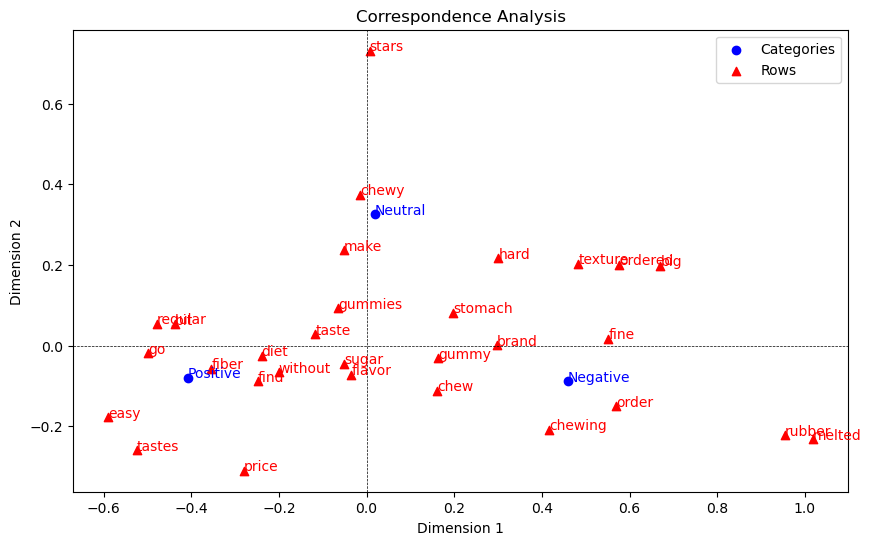

In [187]:
vitafusion = pd.read_csv("Vitafusion.csv")

caPlot(keyWordFunc(vitafusion))

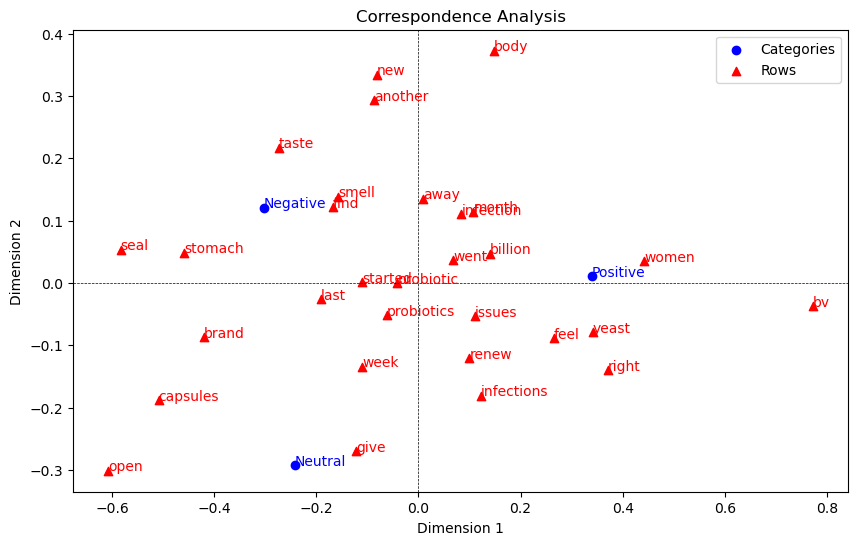

In [188]:
renew = pd.read_csv("Renew.csv")

caPlot(keyWordFunc(renew)) #bv - bacterial vaginosis


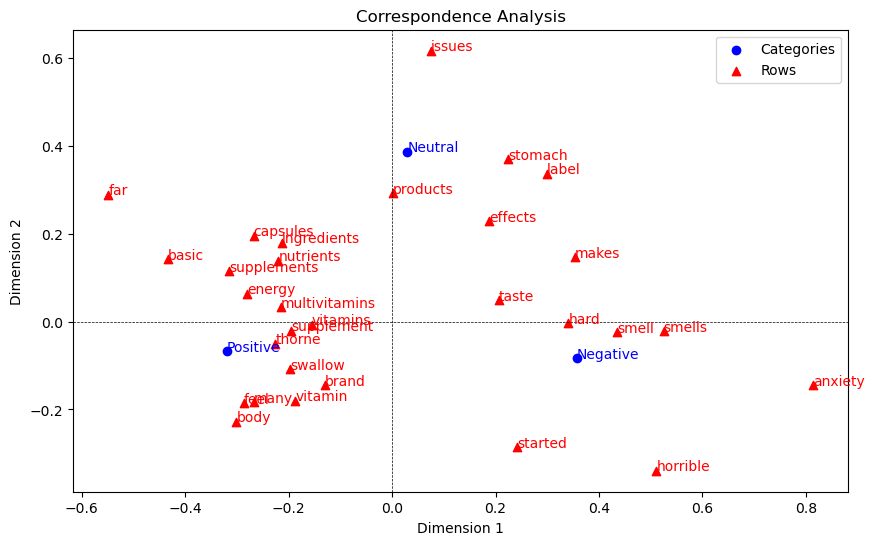

In [189]:
thorneBasic = pd.read_csv("THORNEBasic.csv")

caPlot(keyWordFunc(thorneBasic))


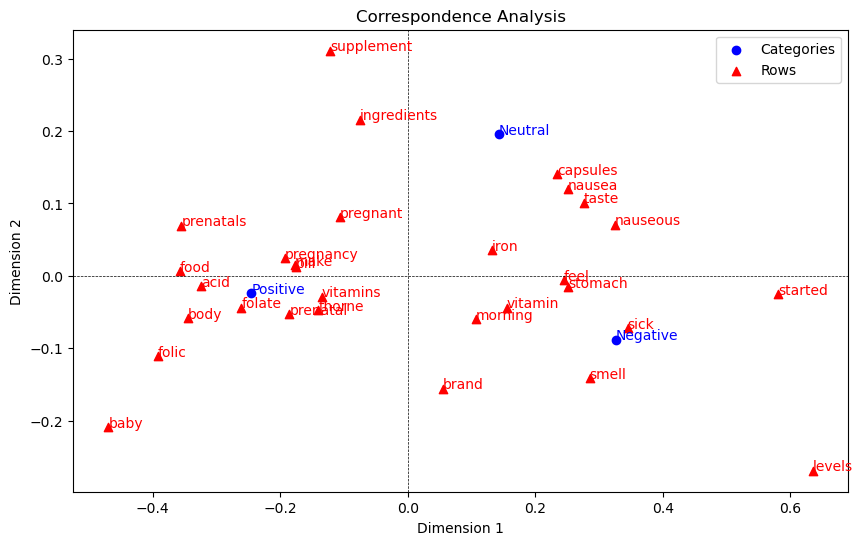

In [190]:
thornePre = pd.read_csv("THORNEPrenatal.csv")

caPlot(keyWordFunc(thornePre))